<a href="https://colab.research.google.com/github/pinballsurgeon/sweeping_analysis/blob/main/emergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## installs

In [26]:
!pip install pytrends
!pip install joypy

# install openai
!pip install openai

## imports

In [56]:
import numpy
import pandas 
import re
import string
from difflib import SequenceMatcher

from pytrends.request import TrendReq
from pytrends         import dailydata
import pytrends
from operator         import index

import joypy
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn 

import openai

import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

# supply openai api key via file 
openai.api_key = open('openai_key').read()


## seed config

In [46]:
# connection strenth minimum boost, base on standard deviation
std_factor = 1.6
pop_threshold = -.5

# seed topics
topics = ['Asthma', 'Bronchitis', 'Sinusitis', 'Emergency', 'Walgreens', 'Cvs', 'Eye', 'Knee', 'Skull', 'Ear', 'Nose', 'Rash', 'Arthritis'
        , 'Tinnitus', 'Burn', 'Allergy', 'Ambulance', 'Accident', 'Poison', 'Cough', 'Watery eye', 'Ringworm', 'Antibiotic', 'Doctor', 'Clinic'
        , 'Hypertension', 'Pharmacy', 'Primary care', 'Bruise', 'Sprain', 'Strain', 'Exczema', 'Cellulitis', 'Abscesses', 'Strep throat'
        , 'Pain', 'Throbbing', 'Irritability', 'Sad', 'Happy', 'Mad' , 'Cancer', 'Surgery', 'Heart', 'Lungs', 'Throat', 'Mouth', 'Toothache'
        , 'Ear infection', 'Diabetes', 'Migranes', 'Pink eye', 'Bladder infection', 'Attention deficit', 'Depression', 'Anxiety']



## helper functions
  1. get_trend_frame(topics, years): returns a dataframe of topic trends
  2. stack_nodes_vertically(df_features):
  3. build_node_labels(df_flat):

In [29]:
### 1. for a given list of topics, return dataframe of interests from pytrend
def get_trend_frame(topics, years):

  # initialize return frame
  df_total = pandas.DataFrame()

  # for each provided 
  for topic in topics:

    # pytrend request
    pytrend = TrendReq()
    pytrend.build_payload(kw_list=[topic]
                         ,geo="US-FL"
                         ,timeframe=( 'today %s-y' % (years)))
    
    # load trend request
    df = pytrend.interest_over_time()

    # add column for new topic
    df_total[topic] = df[topic]

  # drop nans
  df_total = df_total.dropna()

  # return standard frame
  return df_total

In [30]:
### 2. for each topic and interval of time, stack a vertical dataframe of value counts
def stack_nodes_vertically(df_features):

  # initialize buffers resources
  df_stk=pandas.DataFrame()
  globalst=[]

  # for each feature
  for col in df_features:                      # topic

      # for each time interval
      for val in df_features.index.weekofyear: # weeknum

          # time sensitive
          fs_val = df_features[col][val]       # full spectrum
          
          if fs_val > pop_threshold:


            # iterate through each instance of max bin occurence, determining number of weeks written
            for x in range(0,int(abs(fs_val) * 100)):
              
                # build buffer list
                lst = [val, val, col]
                globalst.append(lst)

          else:
                # build buffer list
                lst = [val, None, None]
                globalst.append(lst)

  # materialize vertically flattened
  df_flat = pandas.DataFrame(globalst
                            ,columns=['WeekNum'
                            ,'WeekNum_Rct'
                            ,'Flower_Tot'])
  
  return df_flat

In [31]:
### 3. prefix ridgemap/joyplot labels with weeknum average
def build_node_labels(df_flat):
  
  # get all distinct nodes
  df_stats = df_flat.groupby('Flower_Tot').agg(['mean', 'count']).reset_index()

  # rename columns to node labels
  df_stats.columns = [' '.join(col).strip() for col in df_stats.columns.values]

  # sort by average time interval
  df_stats = df_stats.sort_values(by='WeekNum mean',ascending=True)

  # include average into node label
  df_stats['Name'] = ( ( df_stats['WeekNum mean'] * 100) + 1000).astype('int').astype('str') + ' '+ df_stats['Flower_Tot']

  # update flattened node space with averaged names
  for index, row in df_stats.iterrows():
      df_flat['Flower_Tot'] = df_flat['Flower_Tot'].replace(row['Flower_Tot'], row['Name'])

  return df_flat

In [32]:
### 4. display ridgeplot of time frame, for 
def get_ridgeplot(df_flat):

  # configure and build ridgeplot
  fig, axes = joypy.joyplot(df_flat
                            , column=['WeekNum', 'WeekNum_Rct']
                            , by='Flower_Tot'
                            , overlap=1.2
                            , fill=True
                            , figsize=(22,22)
                            , x_range = [0,52]
                            , colormap=cm.cool                         
                            , ylim='own'
                          )

  # write ridgeplot
  plt.savefig('frank_jj.png')

  # plot
  plt.show()

In [33]:
### 5. send openai question, receive response
def get_openai_response(question):

    # format open au request
    response = openai.Completion.create(
                      engine="text-davinci-001",
                      prompt=question,
                      temperature=.01,
                      max_tokens=250,
                      top_p=1,
                      frequency_penalty=50,
                      presence_penalty=0 )

    # parse and process open ai response
    response_choices = response["choices"]

    # replace blanks
    response = response_choices[0]["text"].strip('\n')

    return response

In [34]:
def swap_tokens(topics, chk_topics, new_topics):

  buffer_lst = []


  # for each full list of topics
  for topic in topics:

    # for each graphed topics
    for chk_topic in chk_topics:

      # if 
      if topic == chk_topic:

        buffer_lst.append(topic)


  for new_topic in new_topics:
    buffer_lst.append(new_topic)


  return buffer_lst


In [35]:
def get_pairwise_similarity(df_features, topics, std_factor):

  # pair wise correlation / similarity
  c = df_features.corr().abs()

  # flatten and sort
  so = c.unstack().sort_values(kind="quicksort")

  # remove low connections
  min_connection_strength = so.mean() + ( std_factor * so.std() )
  min_connection_cutoff = len(so) - len(so[so > min_connection_strength])

  # turn to frame
  df_slice = so[min_connection_cutoff:-len(topics)].to_frame()

  df_slice.reset_index(inplace=True)

  df_slice.columns = ['source','target','weight']

  return df_slice

  #df_slice.hist()

In [36]:
def build_graph_network(df_slice):

  # build graph 
  G = nx.from_pandas_edgelist(df_slice
                            ,'source'          # parent
                            ,'target'          # child
                            , ['weight'])      # relationship


  # define plot area
  plt.figure(3,figsize=(22,22)) 


  # visualize graph 
  nx.draw(G                        
      ,with_labels=True
      ,edge_color='gray'
      ,node_color='white'
      ,font_size=22)
  
  return G

In [37]:
def get_openai_generated_topics(topic):
  responses = []

  # retrieve 
  retrieval = get_openai_response('list objects related to %s' % (topic))
  responses.append(retrieval)

  new_tokens = re.split("; |, |\*|\n",responses[0].lower())

  return new_tokens

## gather, pre-process and stage graph data structure

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':


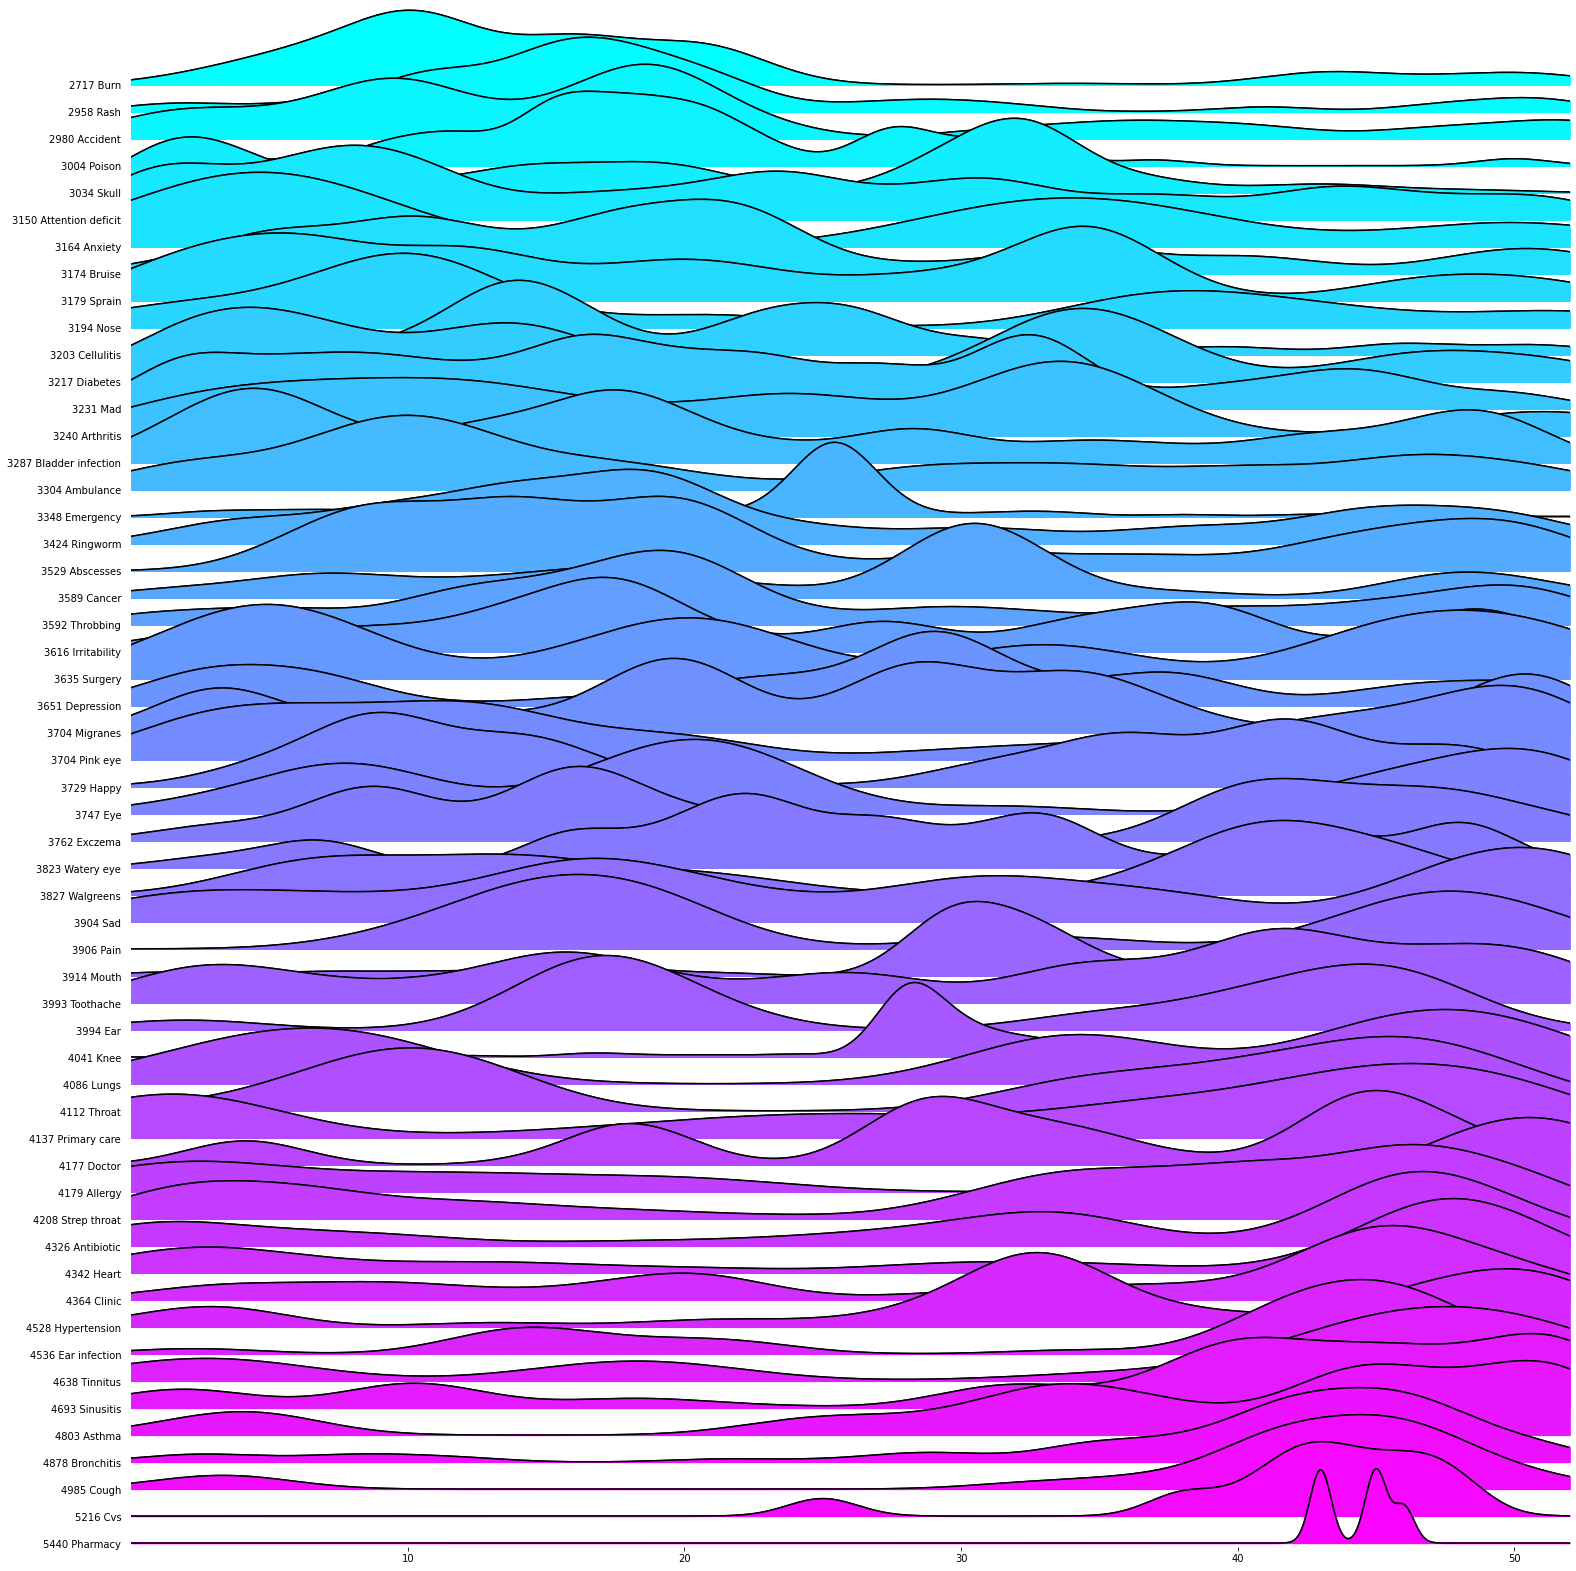

In [47]:
# request features
df_features = get_trend_frame(topics, '5')[topics]

# normalize feature space
df_features=(df_features-df_features.mean())/df_features.std()

# flatten feature space vertically
df_flat = stack_nodes_vertically(df_features)

# build node labels
df_flat = build_node_labels(df_flat)

# display ridgeplot of events
get_ridgeplot(df_flat)

In [45]:
df_features
#df_slice

,Asthma,Bronchitis,Sinusitis,Emergency,Walgreens,Cvs,Eye,Knee,Skull,Ear,...,Mouth,Toothache,Ear infection,Diabetes,Migranes,Pink eye,Bladder infection,Attention deficit,Depression,Anxiety
date,,,,,,,,,,,,,,,,,,,,,
2017-03-12,-0.823767,0.075954,-0.699707,-0.465237,-0.617416,-0.731943,-0.323934,-0.751518,7.150263,-1.393805,...,-1.281733,-1.511491,-0.323431,-0.159517,-1.789758,0.124010,0.913058,0.449372,0.008458,-1.367430
2017-03-19,-0.061795,0.338874,0.541574,-0.587274,-0.509914,-0.564806,0.122223,-0.751518,3.398848,-1.393805,...,-0.388456,-1.189714,-0.532380,-0.439879,-1.230142,0.317822,1.619737,3.866075,-0.121393,-1.367430
2017-03-26,-0.188790,0.233706,0.696735,-0.465237,-0.509914,-0.564806,0.122223,-0.576544,1.854148,-0.283441,...,-0.835095,1.384506,-0.323431,1.382477,0.550455,1.997524,-0.578821,0.138763,1.306970,-0.231712
2017-04-02,-0.061795,0.391458,-0.234226,-0.465237,-0.617416,-0.731943,-0.323934,-0.751518,1.523140,-0.838623,...,0.058183,-0.760677,-0.114482,0.681571,1.110071,0.447030,2.640496,-0.296090,0.787565,-0.373677
2017-04-09,-0.315785,0.233706,-0.854867,-0.343200,-0.509914,-0.648374,-0.547013,-1.276441,1.633476,-1.255009,...,-0.983974,-0.546159,-0.845803,0.961933,1.160945,1.028465,1.070097,0.635738,0.268160,-1.367430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-06,0.954168,-0.555052,-0.079066,0.022911,0.242600,0.187308,1.460695,-0.051621,-0.683574,0.132946,...,-0.388456,-0.975195,-0.323431,-0.019335,-0.263532,-0.974257,0.127858,-1.600650,-0.770650,0.620075
2022-02-13,0.573182,-0.555052,-1.010027,0.022911,0.027596,0.187308,1.014538,2.747969,-0.683574,0.688128,...,-0.835095,-0.117122,0.616840,-0.019335,-0.772274,-0.715841,-0.186222,0.635738,-1.030352,0.904005
2022-02-20,0.319191,-0.449884,0.619155,0.022911,-0.187408,0.103740,1.683774,0.998225,-0.573239,0.271741,...,-0.686215,-0.975195,-0.218956,0.120846,2.280178,0.253218,-0.578821,2.002419,-0.510947,1.045969


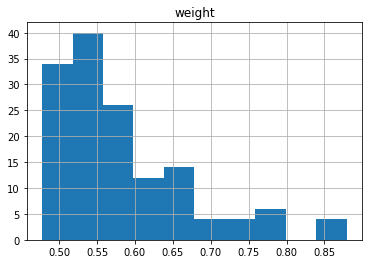

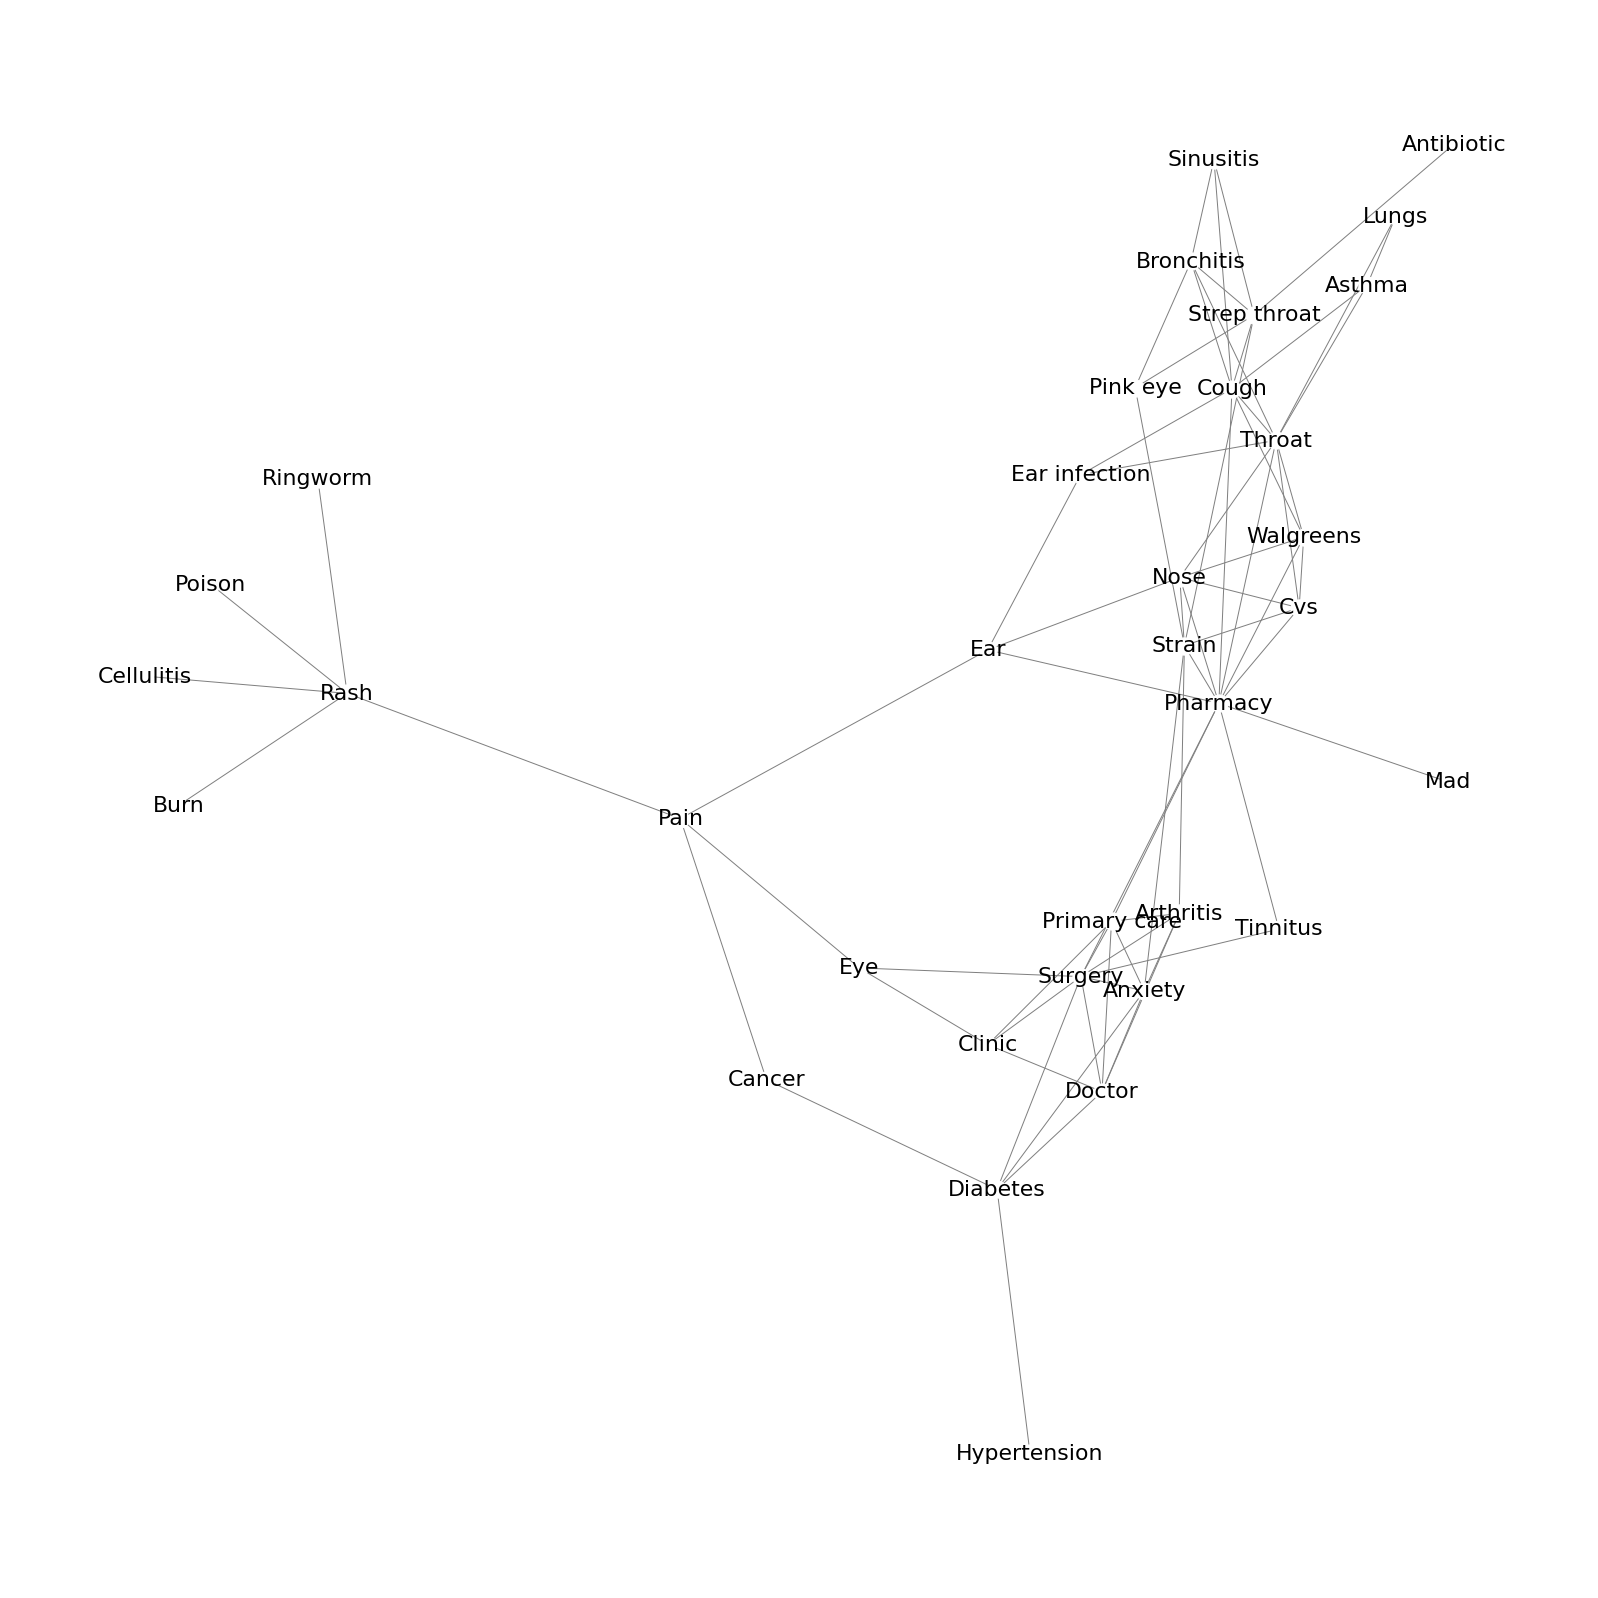

In [40]:
# time-based pairwise similiarity weights
df_slice = get_pairwise_similarity(df_features, topics, std_factor)

# display flattened histogram
df_slice.hist()

# build graph
G = build_graph_network(df_slice)

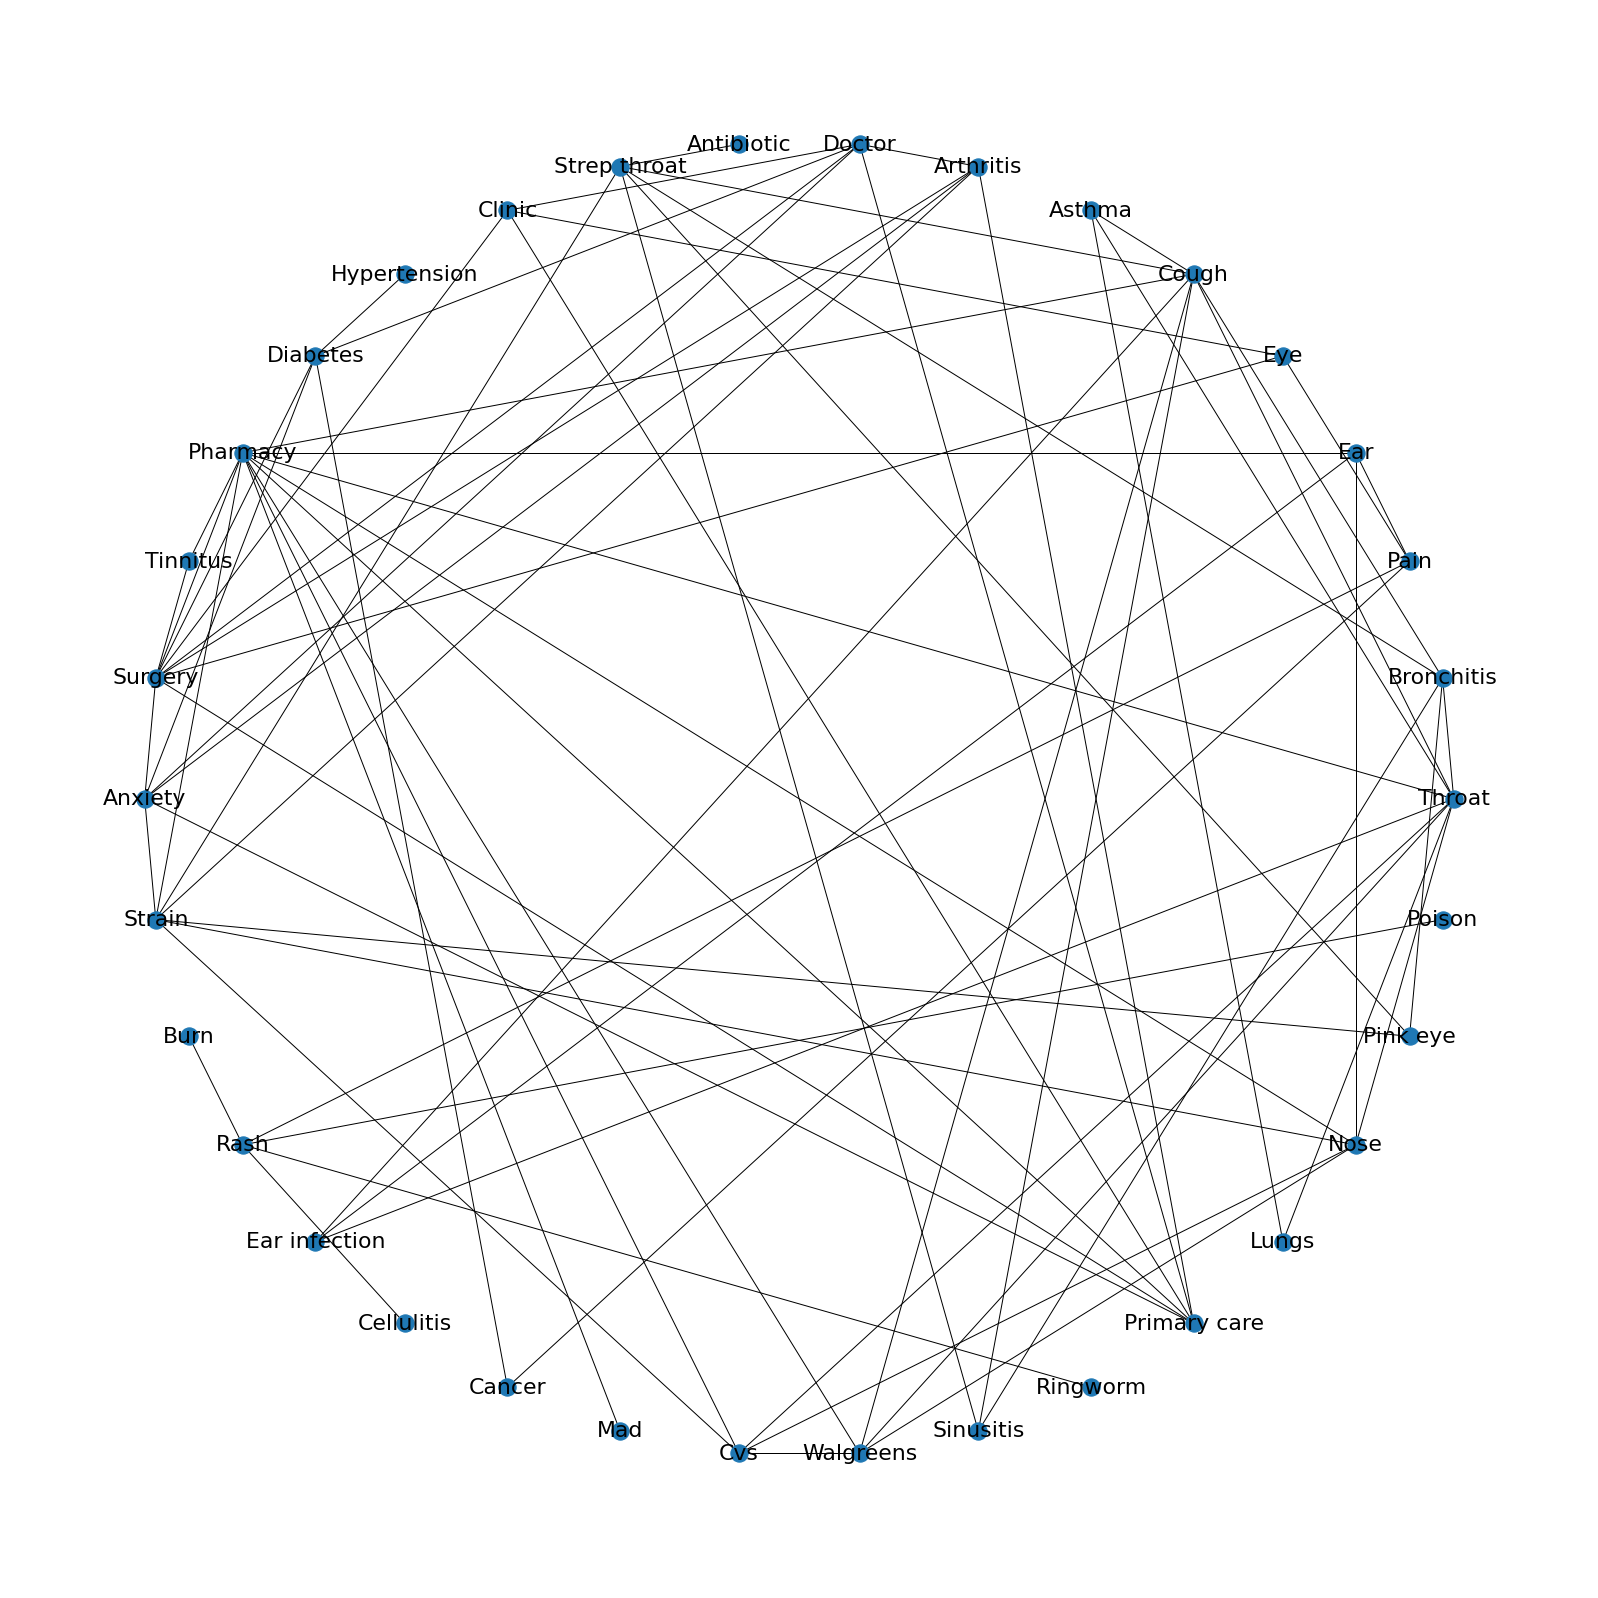

In [54]:
# circler plot
circ_pos = nx.circular_layout(G) 

# define plot area
plt.figure(3,figsize=(22,22)) 

#Use the networkx draw function to easily visualise the graph
nx.draw(G,circ_pos,with_labels=True,font_size=22)


In [66]:
# community detection

# community detection
c = list(greedy_modularity_communities(G))

# how many communities we detected
community_count=len(c)
print('Communities found - %s ' % community_count); print()

for community in range(community_count):
  
  print('Community %d - %s' % (community, sorted(c[community])))

Communities found - 4 

Community 0 - ['Antibiotic', 'Asthma', 'Bronchitis', 'Cough', 'Ear infection', 'Lungs', 'Pink eye', 'Sinusitis', 'Strep throat', 'Throat']
Community 1 - ['Anxiety', 'Arthritis', 'Clinic', 'Diabetes', 'Doctor', 'Eye', 'Hypertension', 'Primary care', 'Surgery']
Community 2 - ['Cvs', 'Ear', 'Mad', 'Nose', 'Pharmacy', 'Strain', 'Tinnitus', 'Walgreens']
Community 3 - ['Burn', 'Cancer', 'Cellulitis', 'Pain', 'Poison', 'Rash', 'Ringworm']


In [59]:


community_0 = sorted(c[0])
community_1 = sorted(c[1])
community_2 = sorted(c[2])

print(community_0)
print(community_1)
print(community_2)

['Antibiotic', 'Asthma', 'Bronchitis', 'Cough', 'Ear infection', 'Lungs', 'Pink eye', 'Sinusitis', 'Strep throat', 'Throat']
['Anxiety', 'Arthritis', 'Clinic', 'Diabetes', 'Doctor', 'Eye', 'Hypertension', 'Primary care', 'Surgery']
['Cvs', 'Ear', 'Mad', 'Nose', 'Pharmacy', 'Strain', 'Tinnitus', 'Walgreens']


In [41]:
### graph properties

# list nodes
G.nodes.items()

# number of edges in graph
G.number_of_edges()

# number of nodes in graph
G.number_of_nodes()

G.get_edge_data(0,1)

In [42]:
lst_buffer = []
graph_topics = list(df_slice['source'].unique())

for graph_topic in graph_topics:
  topic_list = get_openai_generated_topics(graph_topic)

  for topic in topic_list:

    if len(topic) < 10 and len(topic) > 2:

      topic = topic.translate(string.punctuation)
      topic = re.sub(r'[^\w\s]','',topic)
      lst_buffer.append(topic)
  
  print(lst_buffer)



[]
[]
[]
['rings']
['rings', 'eyeball', 'eyesight']
['rings', 'eyeball', 'eyesight']
['rings', 'eyeball', 'eyesight']
['rings', 'eyeball', 'eyesight']
['rings', 'eyeball', 'eyesight', ' who']
['rings', 'eyeball', 'eyesight', ' who']
['rings', 'eyeball', 'eyesight', ' who']
['rings', 'eyeball', 'eyesight', ' who']
['rings', 'eyeball', 'eyesight', ' who']
['rings', 'eyeball', 'eyesight', ' who']
['rings', 'eyeball', 'eyesight', ' who']
['rings', 'eyeball', 'eyesight', ' who']
['rings', 'eyeball', 'eyesight', ' who']
['rings', 'eyeball', 'eyesight', ' who']
['rings', 'eyeball', 'eyesight', ' who']
['rings', 'eyeball', 'eyesight', ' who']
['rings', 'eyeball', 'eyesight', ' who']
['rings', 'eyeball', 'eyesight', ' who']
['rings', 'eyeball', 'eyesight', ' who']
['rings', 'eyeball', 'eyesight', ' who']
['rings', 'eyeball', 'eyesight', ' who']
['rings', 'eyeball', 'eyesight', ' who']
['rings', 'eyeball', 'eyesight', ' who']
['rings', 'eyeball', 'eyesight', ' who']
['rings', 'eyeball', 'eyesigh

In [43]:
lst_buffer.append('the fireworks')

In [44]:
def reduce_similiar_topics(lst_ref, lst_new)):
  
  



  print('%s vs %s' % (lst_buffer[4], lst_buffer[8]))
  SequenceMatcher(None, lst_buffer[4], lst_buffer[8]).ratio()

SyntaxError: ignored

In [ ]:
chk_topics = list(df_slice['source'].unique())

In [ ]:
swap_tokens(topics, chk_topics, new_tokens)